# Balloon con parte instantanea y lag para VARLiNGAM

In [23]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [24]:
pip install lingam

In [25]:
import itertools
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.utils import check_array, resample
from statsmodels.tsa.vector_ar.var_model import VAR

from lingam.base import _BaseLiNGAM
from lingam.bootstrap import BootstrapResult
from lingam.direct_lingam import DirectLiNGAM
from lingam.hsic import hsic_test_gamma
from lingam.utils import predict_adaptive_lasso, find_all_paths, calculate_total_effect

class VARLiNGAM:
    """Implementation of VAR-LiNGAM Algorithm [1]_

    References
    ----------
    .. [1] Aapo Hyvärinen, Kun Zhang, Shohei Shimizu, Patrik O. Hoyer.
       Estimation of a Structural Vector Autoregression Model Using Non-Gaussianity.
       Journal of Machine Learning Research, 11: 1709-1731, 2010.
    """

    def __init__(
        self,
        lags=1,
        prune=True,
        criterion=None,  ##########
        alpha_lasso=0.1,    #############
        ar_coefs=None,
        lingam_model=None,
        random_state=None,
    ):
        """Construct a VARLiNGAM model.

        Parameters
        ----------
        lags : int, optional (default=1)
            Number of lags.
        criterion : {‘aic’, ‘fpe’, ‘hqic’, ‘bic’, None}, optional (default='bic')
            Criterion to decide the best lags within ``lags``.
            Searching the best lags is disabled if ``criterion`` is ``None``.
        prune : boolean, optional (default=True)
            Whether to prune the adjacency matrix of lags.
        ar_coefs : array-like, optional (default=None)
            Coefficients of AR model. Estimating AR model is skipped if specified ``ar_coefs``.
            Shape must be (``lags``, n_features, n_features).
        lingam_model : lingam object inherits 'lingam._BaseLiNGAM', optional (default=None)
            LiNGAM model for causal discovery. If None, DirectLiNGAM algorithm is selected.
        random_state : int, optional (default=None)
            ``random_state`` is the seed used by the random number generator.
        """
        self._lags = lags
        self._criterion = criterion
        self._prune = prune
        self._ar_coefs = (
            check_array(ar_coefs, allow_nd=True) if ar_coefs is not None else None
        )
        self._lingam_model = lingam_model
        self._random_state = random_state
        self.alpha_lasso = alpha_lasso          ########################

    def fit(self, X):
        """Fit the model to X.

        Parameters
        ----------
        X: array-like, shape (n_samples, n_features)
            Training data, where ``n_samples`` is the number of samples
            and ``n_features`` is the number of features.

        returns
        -------
        self : object
            Returns the instance itself.
        """
        self._causal_order = None
        self._adjacency_matrices = None

        X = check_array(X)

        lingam_model = self._lingam_model
        if lingam_model is None:
            lingam_model = DirectLiNGAM()
        elif not isinstance(lingam_model, _BaseLiNGAM):
            raise ValueError("lingam_model must be a subclass of _BaseLiNGAM")

        M_taus = self._ar_coefs

        if M_taus is None:
            M_taus, lags, residuals = self._estimate_var_coefs(X)
        else:
            lags = M_taus.shape[0]
            residuals = self._calc_residuals(X, M_taus, lags)

        self._ar_coefs = M_taus
        self._lags = lags
        self._residuals = residuals

        model = lingam_model
        model.fit(residuals)

        B_taus = self._calc_b(X, model.adjacency_matrix_, M_taus)

        if self._prune:
            B_taus = self._pruning(X, B_taus, model.causal_order_)

        self._causal_order = model.causal_order_
        self._adjacency_matrices = B_taus

        return self

    def bootstrap(self, X, n_sampling):
        """Evaluate the statistical reliability of DAG based on the bootstrapping.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where ``n_samples`` is the number of samples
            and ``n_features`` is the number of features.
        n_sampling : int
            Number of bootstrapping samples.

        Returns
        -------
        result : TimeseriesBootstrapResult
            Returns the result of bootstrapping.
        """
        X = check_array(X)

        n_samples = X.shape[0]
        n_features = X.shape[1]

        # store initial settings
        ar_coefs = self._ar_coefs
        lags = self._lags

        criterion = self._criterion
        self._criterion = None

        self.fit(X)

        fitted_ar_coefs = self._ar_coefs
        residuals = self._residuals

        total_effects = np.zeros(
            [n_sampling, n_features, n_features * (1 + self._lags)]
        )

        adjacency_matrices = []
        for i in range(n_sampling):
            sampled_residuals = resample(residuals, n_samples=n_samples)

            resampled_X = np.zeros((n_samples, n_features))
            for j in range(n_samples):
                if j < lags:
                    resampled_X[j, :] = sampled_residuals[j]
                    continue

                ar = np.zeros((1, n_features))
                for t, M in enumerate(fitted_ar_coefs):
                    ar += np.dot(M, resampled_X[j - t - 1, :].T).T

                resampled_X[j, :] = ar + sampled_residuals[j]

            # restore initial settings
            self._ar_coefs = ar_coefs
            self._lags = lags

            self.fit(resampled_X)
            am = np.concatenate([*self._adjacency_matrices], axis=1)
            adjacency_matrices.append(am)

            # total effects
            for c, to in enumerate(reversed(self._causal_order)):
                # time t
                for from_ in self._causal_order[: n_features - (c + 1)]:
                    total_effects[i, to, from_] = self.estimate_total_effect2(
                        n_features, from_, to
                    )

                # time t-tau
                for lag in range(self._lags):
                    for from_ in range(n_features):
                        total_effects[
                            i, to, from_ + n_features * (lag + 1)
                        ] = self.estimate_total_effect2(n_features, from_, to, lag + 1)

        self._criterion = criterion

        return VARBootstrapResult(adjacency_matrices, total_effects)

    def estimate_total_effect(self, X, from_index, to_index, from_lag=0):
        """Estimate total effect using causal model.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Original data, where n_samples is the number of samples
            and n_features is the number of features.
        from_index :
            Index of source variable to estimate total effect.
        to_index :
            Index of destination variable to estimate total effect.

        Returns
        -------
        total_effect : float
            Estimated total effect.
        """
        X = check_array(X)
        n_features = X.shape[1]

        # Check from/to causal order
        if from_lag == 0:
            from_order = self._causal_order.index(from_index)
            to_order = self._causal_order.index(to_index)
            if from_order > to_order:
                warnings.warn(
                    f"The estimated causal effect may be incorrect because "
                    f"the causal order of the destination variable (to_index={to_index}) "
                    f"is earlier than the source variable (from_index={from_index})."
                )

        # X + lagged X
        X_joined = np.zeros((X.shape[0], X.shape[1] * (1 + self._lags + from_lag)))
        for p in range(1 + self._lags + from_lag):
            pos = n_features * p
            X_joined[:, pos : pos + n_features] = np.roll(X[:, 0:n_features], p, axis=0)

        # from_index + parents indices
        am = np.concatenate([*self._adjacency_matrices], axis=1)
        parents = np.where(np.abs(am[from_index]) > 0)[0]
        from_index = (
            from_index if from_lag == 0 else from_index + (n_features * from_lag)
        )
        parents = parents if from_lag == 0 else parents + (n_features * from_lag)
        predictors = [from_index]
        predictors.extend(parents)

        # estimate total effect
        lr = LinearRegression()
        lr.fit(X_joined[:, predictors], X_joined[:, to_index])

        return lr.coef_[0]

    def estimate_total_effect2(self, n_features, from_index, to_index, from_lag=0):
        """Estimate total effect using causal model.

        Parameters
        ----------
        n_features :
            The number of features.
        from_index :
            Index of source variable to estimate total effect.
        to_index :
            Index of destination variable to estimate total effect.

        Returns
        -------
        total_effect : float
            Estimated total effect.
        """
        # Check from/to causal order
        if from_lag == 0:
            from_order = self._causal_order.index(from_index)
            to_order = self._causal_order.index(to_index)
            if from_order > to_order:
                warnings.warn(
                    f"The estimated causal effect may be incorrect because "
                    f"the causal order of the destination variable (to_index={to_index}) "
                    f"is earlier than the source variable (from_index={from_index})."
                )

        # from_index + parents indices
        am = np.concatenate([*self._adjacency_matrices], axis=1)
        am = np.pad(am, [(0, am.shape[1] - am.shape[0]), (0, 0)])
        from_index = (
            from_index if from_lag == 0 else from_index + (n_features * from_lag)
        )

        effect = calculate_total_effect(am, from_index, to_index)

        return effect

    def get_error_independence_p_values(self):
        """Calculate the p-value matrix of independence between error variables.

        Returns
        -------
        independence_p_values : array-like, shape (n_features, n_features)
            p-value matrix of independence between error variables.
        """
        nn = self.residuals_
        B0 = self._adjacency_matrices[0]
        E = np.dot(np.eye(B0.shape[0]) - B0, nn.T).T
        n_samples = E.shape[0]
        n_features = E.shape[1]

        p_values = np.zeros([n_features, n_features])
        for i, j in itertools.combinations(range(n_features), 2):
            _, p_value = hsic_test_gamma(
                np.reshape(E[:, i], [n_samples, 1]), np.reshape(E[:, j], [n_samples, 1])
            )
            p_values[i, j] = p_value
            p_values[j, i] = p_value

        return p_values

    def _estimate_var_coefs(self, X):
        """Estimate coefficients of VAR"""
        # XXX: VAR.fit() is not searching lags correctly
        if self._criterion not in ["aic", "fpe", "hqic", "bic"]:
            var = VAR(X)
            result = var.fit(maxlags=self._lags, trend="n")
        else:
            min_value = float("Inf")
            result = None

            for lag in range(1, self._lags + 1):
                var = VAR(X)
                fitted = var.fit(maxlags=lag, ic=None, trend="n")

                value = getattr(fitted, self._criterion)
                if value < min_value:
                    min_value = value
                    result = fitted

        return result.coefs, result.k_ar, result.resid

    def _calc_residuals(self, X, M_taus, lags):
        """Calculate residulas"""
        X = X.T
        n_features = X.shape[0]
        n_samples = X.shape[1]

        residuals = np.zeros((n_features, n_samples))
        for t in range(n_samples):
            if t - lags < 0:
                continue

            estimated = np.zeros((X.shape[0], 1))
            for tau in range(1, lags + 1):
                estimated += np.dot(M_taus[tau - 1], X[:, t - tau].reshape((-1, 1)))

            residuals[:, t] = X[:, t] - estimated.reshape((-1,))

        residuals = residuals[:, lags:].T

        return residuals

    def _calc_b(self, X, B0, M_taus):
        """Calculate B"""
        n_features = X.shape[1]

        B_taus = np.array([B0])

        for M in M_taus:
            B_t = np.dot((np.eye(n_features) - B0), M)
            B_taus = np.append(B_taus, [B_t], axis=0)

        return B_taus

    def _pruning(self, X, B_taus, causal_order):
        """Prune edges"""
        n_features = X.shape[1]

        stacked = [np.flip(X, axis=0)]
        for i in range(self._lags):
            stacked.append(np.roll(stacked[-1], -1, axis=0))
        blocks = np.array(list(zip(*stacked)))[: -self._lags]

        for i in range(n_features):
            causal_order_no = causal_order.index(i)
            ancestor_indexes = causal_order[:causal_order_no]

            obj = np.zeros((len(blocks)))
            exp = np.zeros((len(blocks), causal_order_no + n_features * self._lags))
            for j, block in enumerate(blocks):
                obj[j] = block[0][i]
                exp[j:] = np.concatenate(
                    [block[0][ancestor_indexes].flatten(), block[1:][:].flatten()],
                    axis=0,
                )

            # adaptive lasso
            predictors = [i for i in range(exp.shape[1])]
            target = len(predictors)
            X_con = np.concatenate([exp, obj.reshape(-1, 1)], axis=1)
            #coef = predict_adaptive_lasso(X_con, predictors, target)
            coef = predict_adaptive_lasso(X_con, predictors, target,
                              gamma=1.0, alpha=self.alpha_lasso)


            B_taus[0][i, ancestor_indexes] = coef[:causal_order_no]
            for j in range(len(B_taus[1:])):
                B_taus[j + 1][i, :] = coef[
                    causal_order_no + n_features * j :
                    causal_order_no + n_features * j + n_features
                ]

        return B_taus

    @property
    def causal_order_(self):
        """Estimated causal ordering.

        Returns
        -------
        causal_order_ : array-like, shape (n_features)
            The causal order of fitted model, where
            n_features is the number of features.
        """
        return self._causal_order

    @property
    def adjacency_matrices_(self):
        """Estimated adjacency matrix.

        Returns
        -------
        adjacency_matrices_ : array-like, shape (lags, n_features, n_features)
            The adjacency matrix of fitted model, where
            n_features is the number of features.
        """
        return self._adjacency_matrices

    @property
    def residuals_(self):
        """Residuals of regression.

        Returns
        -------
        residuals_ : array-like, shape (n_samples)
            Residuals of regression, where n_samples is the number of samples.
        """
        return self._residuals

In [26]:
def predict_adaptive_lasso(X, predictors, target, gamma=1.0, alpha=0.1):

    """Predict with Adaptive Lasso.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.
    predictors : array-like, shape (n_predictors)
        Indices of predictor variable.
    target : int
        Index of target variable.

    Returns
    -------
    coef : array-like, shape (n_features)
        Coefficients of predictor variable.
    """
    # Standardize X
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    # Pruning with Adaptive Lasso
    lr = LinearRegression()
    lr.fit(X_std[:, predictors], X_std[:, target])
    weight = np.power(np.abs(lr.coef_), gamma)
    #reg = LassoLarsIC(criterion="bic")
    #reg.fit(X_std[:, predictors] * weight, X_std[:, target])

    from sklearn.linear_model import Lasso

    # Ajuste con Lasso clásico (alpha controla penalización)
    reg = Lasso(alpha=alpha)      # <-- agregar este parámetro en la firma
    reg.fit(X_std[:, predictors] * weight, X_std[:, target])

    pruned_idx = np.abs(reg.coef_ * weight) > 0.0

    # Calculate coefficients of the original scale
    coef = np.zeros(reg.coef_.shape)
    if pruned_idx.sum() > 0:
        lr = LinearRegression()
        pred = np.array(predictors)
        lr.fit(X[:, pred[pruned_idx]], X[:, target])
        coef[pruned_idx] = lr.coef_

    return coef

## Intento 8

In [27]:
pip install lingam

In [28]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import check_array
from lingam import DirectLiNGAM
import random
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso

# Para que encuentre BalloonModelNet.py en tu Drive
sys.path.append("/content/drive/MyDrive/Balloon")

from BalloonModelNet import gen_network_stimulus, BalloonNetwork_roiwise

A_custom_path = "/content/drive/MyDrive/Balloon/A_custom.npy"
A_custom = np.load(A_custom_path)

print("A_custom shape:", A_custom.shape)

sys.path.append("/content/drive/MyDrive/Balloon/scripts")

from hrf_spm import spm_hrf_compat

# helper para quitar la diagonal al graficar
def zero_diag(M):
    M = np.array(M, dtype=float).copy()
    np.fill_diagonal(M, 0.0)
    return M

A_custom shape: (10, 10)


In [29]:
def plot_matrices(true_list, est_list, titles, cmap="bwr", suptitle=None):
    """
    true_list: [A_true_global, A_true_inst, A_true_lag]
    est_list : [A_est_global,  A_est_inst,  A_est_lag]
    titles   : ["Global", "Instantaneous", "With lag"]
    """

    # Remove diagonal (do not show self-connections)
    true_list = [zero_diag(M) for M in true_list]
    est_list  = [zero_diag(M) for M in est_list]

    # Common range for all heatmaps
    all_vals = np.concatenate([M.flatten() for M in (true_list + est_list)])
    vmin = -1
    vmax = 1

    fig, axes = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)

    last_im = None
    for j in range(3):
        # Row 1: True
        im = axes[0, j].imshow(true_list[j], vmin=vmin, vmax=vmax, cmap=cmap)
        axes[0, j].set_title(f"True – {titles[j]}")
        axes[0, j].set_xticks([])
        axes[0, j].set_yticks([])

        # Row 2: Estimated
        axes[1, j].imshow(est_list[j], vmin=vmin, vmax=vmax, cmap=cmap)
        axes[1, j].set_title(f"Estimated – {titles[j]}")
        axes[1, j].set_xticks([])
        axes[1, j].set_yticks([])

        last_im = im

    # A single colorbar
    cbar = fig.colorbar(last_im, ax=axes.ravel().tolist(), shrink=0.75, pad=0.02)
    cbar.set_label("Connection weight")

    if suptitle is not None:
        fig.suptitle(suptitle, y=1.02)

    plt.show()

In [30]:
def estimate_B0_B1_varlingam(X, lags=1, scale=True):
    """
    X: array (T, D) con la serie temporal (neur_eff, neur_deconv, etc.)
    Devuelve:
      B0_inst: matriz instantánea D×D
      B_lag:   array (lags, D, D) con matrices con retardo
      A_red:   coeficientes del VAR reducido (lags, D, D)
    """

    X = np.asarray(X)
    T, D = X.shape

    # 1) Opcional: escalar
    if scale:
        scaler = StandardScaler()
        X_proc = scaler.fit_transform(X)
    else:
        X_proc = X

    # 2) Ajustar VAR reducido
    var_model = VAR(X_proc)
    res = var_model.fit(lags)

    # A_red[k] es la matriz A_{k+1} del VAR reducido
    A_red = res.coefs.copy()          # shape (lags, D, D)
    U = res.resid                     # residuos (T-lags, D)

    # 3) LiNGAM en los residuos -> B0 (instantáneo)
    dl = DirectLiNGAM()
    dl.fit(U)
    B0_inst = dl.adjacency_matrix_.copy()   # D×D, efectos instantáneos

    # 4) Recuperar matrices con lag: B_k = (I - B0) A_k
    I = np.eye(D)
    B_lag = np.zeros_like(A_red)
    for k in range(lags):
        B_lag[k] = (I - B0_inst) @ A_red[k]

    return B0_inst, B_lag, A_red

In [31]:
# =====================================================
# PIPELINE COMPLETO:
#  A_true  ->  Balloon  ->  VARLiNGAM  ->  Figura
# =====================================================

# 1) Parámetros de simulación
D = 10               # número de nodos
Nsamples = 300
TR = 1.0
timeline = TR * np.arange(Nsamples)

# 3) Estímulos de red
U = gen_network_stimulus(timeline, D, nblocks=5, duration_range=(1, 3))
print("U shape:", U.shape)  # (T, D)

# 4) Simular Balloon con parte instantánea y lag
BalloonNetwork = BalloonNetwork_roiwise(
    timing=timeline,
    unodes=U,
    A=A_custom,
    p_inst=0.7,     # 70% de conexiones a parte instantánea (ajustable)
    use_lag=True,
    lag_scale=0.3   # fuerza del término con lag (ajustable)
)

# 5) Extraer matrices reales desde Balloon
A_true_global = BalloonNetwork['Adjacency']        # global (debería ≈ A_true)
A_true_inst   = BalloonNetwork['Adjacency_inst']   # parte instantánea
A_true_lag    = BalloonNetwork['Adjacency_lag']    # parte con lag

print("A_true_global:", A_true_global.shape)
print("A_true_inst  :", A_true_inst.shape)
print("A_true_lag   :", A_true_lag.shape)

# 6) Tomar serie neuronal efectiva (inst+lag) para VARLiNGAM
X = BalloonNetwork['neur_eff']   # shape (T, D)
print("X shape (neur_eff):", X.shape)

U shape: (300, 10)
node 1
node 2
node 3
node 4
node 5
node 6
node 7
node 8
node 9
node 10
A_true_global: (10, 10)
A_true_inst  : (10, 10)
A_true_lag   : (10, 10)
X shape (neur_eff): (299, 10)


BOLD shape: (149, 10)
TR estimado: 1.0


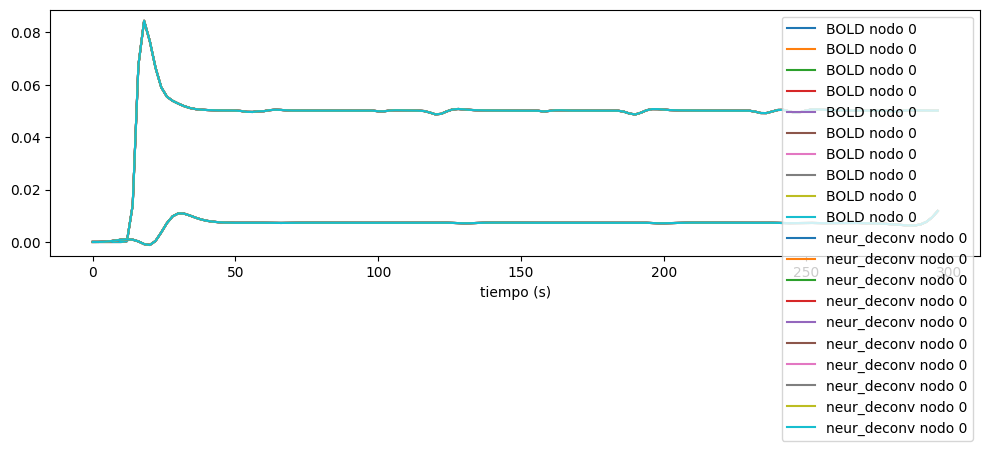

In [32]:
# ============================
# Deconvolución BOLD -> neur_deconv
# ============================

bold = BalloonNetwork['bold']       # (T, D)
tbold = BalloonNetwork['tbold']     # tiempos
T, D = bold.shape

print("BOLD shape:", bold.shape)

TR_est = 1.0
print("TR estimado:", TR_est)

# Vector de tiempo para la HRF (por ejemplo 32 s)
t_hrf = np.arange(0, 32, TR_est)

# HRF canónica usando tu archivo hrf_spm.py
hrf = spm_hrf_compat(t_hrf)

from scipy.linalg import toeplitz

def make_hrf_toeplitz(hrf, n_scans):
    col = np.r_[hrf[0], np.zeros(n_scans - 1)]
    row = np.r_[hrf, np.zeros(n_scans - 1 - (len(hrf) - 1))]
    H = toeplitz(col, row)
    return H[:n_scans, :n_scans]

def deconvolve_bold(y, hrf, lam=10.0):
    T = len(y)
    H = make_hrf_toeplitz(hrf, T)
    A = H.T @ H + lam * np.eye(T)
    b = H.T @ y
    x_hat = np.linalg.solve(A, b)
    return x_hat

# Deconvolución por ROI
neur_deconv = np.zeros_like(bold)

for j in range(D):
    neur_deconv[:, j] = deconvolve_bold(bold[:, j], hrf, lam=10.0)

# Chequear cómo se ve en un nodo
inode = 0
plt.figure(figsize=(10,4))
plt.plot(tbold, bold[:, inode], label="BOLD nodo 0")
plt.plot(tbold, neur_deconv[:, inode], label="neur_deconv nodo 0")
plt.xlabel("tiempo (s)")
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
from sklearn.exceptions import ConvergenceWarning

X = BalloonNetwork['neur_eff']  # (T, D)

# 1) Detectar columnas con varianza casi cero
var_cols = X.var(axis=0)
mask_non_const = var_cols > 1e-6   # umbral, puedes ajustarlo

print("Varianzas por nodo:", var_cols)
print("Nodos no constantes:", np.where(mask_non_const)[0])

X_reduced = X[:, mask_non_const]   # solo columnas “útiles”

# 2) Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# 3) Ajustar VARLiNGAM sobre las columnas reducidas
model = VARLiNGAM(lags=1, prune=True, criterion=None, alpha_lasso=0.00002)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    model.fit(X_scaled)

A_est_reduced = model.adjacency_matrices_[0]   # matriz k×k, k = nº de columnas útiles

Varianzas por nodo: [2.28053989e-01 0.00000000e+00 5.62477459e-03 2.87644350e-04
 2.63508070e-02 1.13330347e+00 6.86488246e-05 4.46593097e-05
 3.98066592e-02 5.26136035e-02]
Nodos no constantes: [0 2 3 4 5 6 7 8 9]


In [34]:
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning

# ============================
# 1. Serie neuronal deconvolucionada
# ============================
X_dec = neur_deconv            # (T, D)
D = X_dec.shape[1]

# ============================
# 2. Quitar columnas casi constantes
# ============================
var_cols_dec = X_dec.var(axis=0)
mask_non_const_dec = var_cols_dec > 1e-6

print("Varianzas (deconv):", var_cols_dec)
print("Nodos no constantes (deconv):", np.where(mask_non_const_dec)[0])

X_dec_reduced = X_dec[:, mask_non_const_dec]   # T × k

# ============================
# 3. Escalado
# ============================
scaler_dec = StandardScaler()
X_dec_scaled = scaler_dec.fit_transform(X_dec_reduced)

# ============================
# 4. Ajustar VARLiNGAM
# ============================
model_dec = VARLiNGAM(
    lags=1,
    prune=True,
    criterion=None,
    alpha_lasso=0.002   # mismo orden que el branch original
)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    model_dec.fit(X_dec_scaled)

A_est_reduced_dec = model_dec.adjacency_matrices_[0]   # k × k

# ============================
# 5. Reconstruir matriz D×D
# ============================
A_est_global_dec = np.zeros((D, D))
A_est_global_dec[np.ix_(mask_non_const_dec, mask_non_const_dec)] = A_est_reduced_dec

A_est_inst_dec = A_est_global_dec.copy()
A_est_lag_dec  = A_est_global_dec.copy()

print("A_est_global_dec shape:", A_est_global_dec.shape)

Varianzas (deconv): [4.45484350e-06 0.00000000e+00 1.73687816e-07 1.22237034e-08
 3.96490943e-06 3.11691622e-05 1.84422753e-08 1.56155844e-08
 2.66554199e-06 1.87856211e-06]
Nodos no constantes (deconv): [0 4 5 8 9]
A_est_global_dec shape: (10, 10)


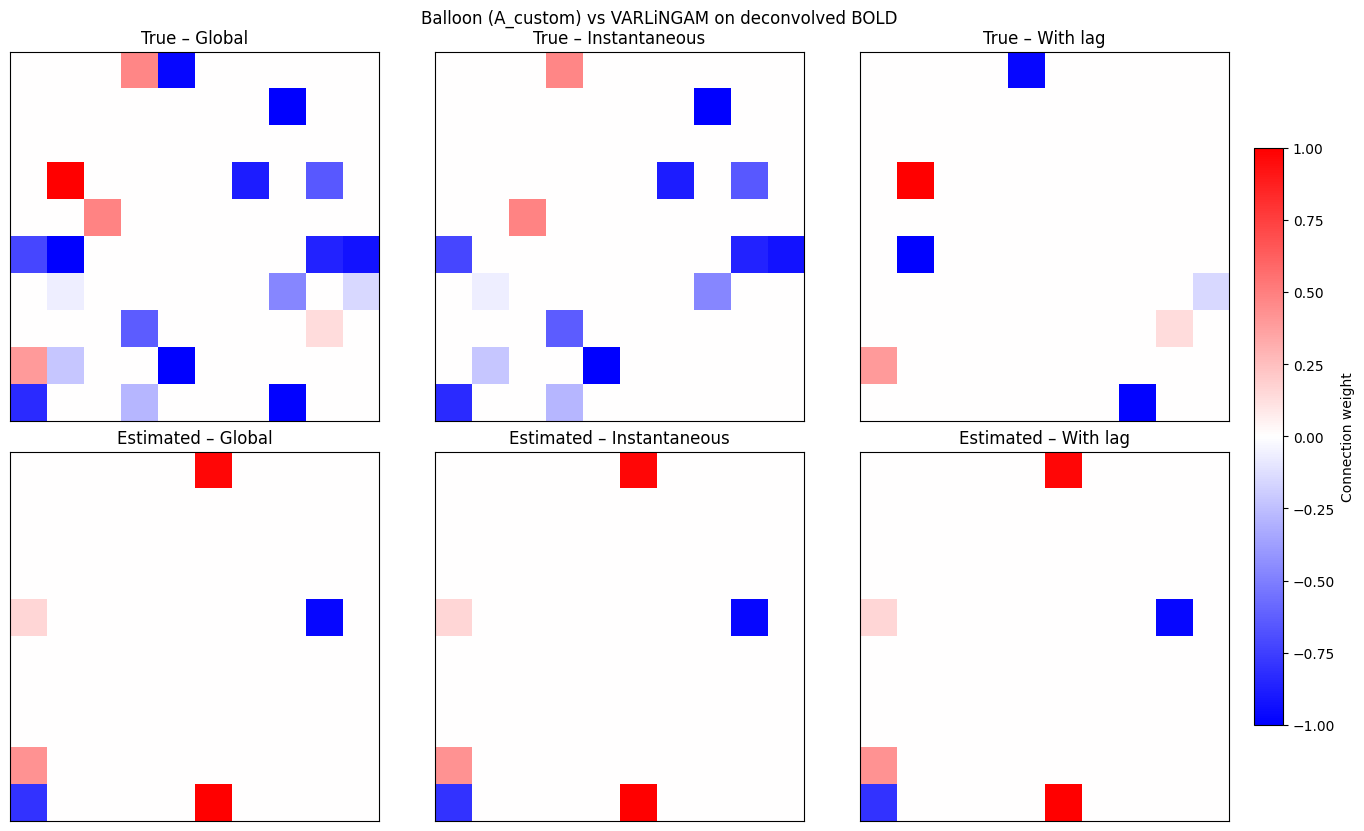

In [35]:
plot_matrices(
    true_list=[A_true_global, A_true_inst, A_true_lag],
    est_list=[A_est_global_dec, A_est_inst_dec, A_est_lag_dec],
    titles=["Global", "Instantaneous", "With lag"],
    suptitle="Balloon (A_custom) vs VARLiNGAM on deconvolved BOLD"
)